# Interpolate From `MeshArray` To Given Position

Each `MeshArray` contains an array of elementary arrays that (1) are connected at their edges and (2) collectively form a global grid. Overall grid specifications are contained within `gcmgrid` instances, which merely define array sizes and how e.g. grid variables are represented in memory. Importantly, it is only when e.g. grid variables are read from file that sizable memory is allocated.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

## Interpolation Code

- get map of tile numbers
- find nearest neighbor


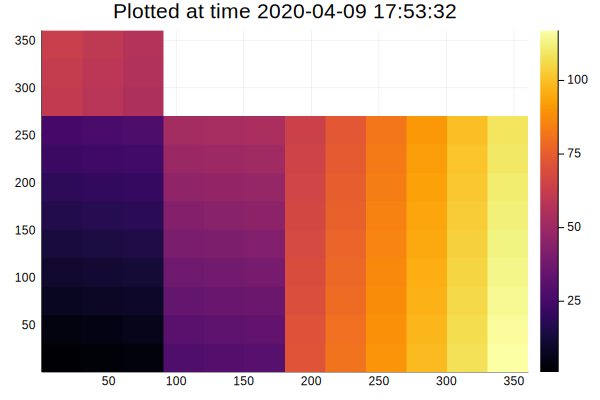

In [4]:
#get map of tile numbers

using MITgcmTools
ni=30; nj=30;
tile=TileMap(γ,ni,nj)
qwckplot(tile)

In [7]:
# find nearest neighbor

using NearestNeighbors

#XC=collect(0.1:0.5:2.1); YC=collect(0.1:0.5:2.1);
XC=0.1; YC=0.1;

Γ=GridLoad(γ)
XC_a=write(Γ["XC"])
YC_a=write(Γ["YC"])
tile_a=write(tile)
kk=findall(isfinite.(XC_a))

x=sin.(pi/2 .-YC_a[kk]*pi/180).*cos.(XC_a[kk]*pi/180);
y=sin.(pi/2 .-YC_a[kk]*pi/180).*sin.(XC_a[kk]*pi/180);
z=cos.(pi/2 .-YC_a[kk]*pi/180);

xx=sin.(pi/2 .-YC*pi/180).*cos.(XC*pi/180);
yy=sin.(pi/2 .-YC*pi/180).*sin.(XC*pi/180);
zz=cos.(pi/2 .-YC*pi/180);

kdtree = KDTree([x y z]')
idxs, dists = knn(kdtree, [xx yy zz]', 4, true)

ik=[idxs[i][1] for i in 1:length(XC)]
[XC_a[ik] YC_a[ik]]

1×2 Array{Float64,2}:
 0.5  0.199365